In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.rnn_optimizer import kl_divergence
from utils.utils import Experiment, get_model, create_def_argparser, get_experiment, create_logger, save_exper
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, create_x_val_array, plot_kl_div_parts
from utils.plots import get_exper_loss_data, plot_loss_over_tsteps, plot_exper_losses, plot_parm_loss_steps
from utils.plots import plot_qt_mode_hist, plot_qt_detailed_stats
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [# Meta V3 model regression
                  (True, "run_20170719_08_53_21_metaV1_40ep_50ops_lr5e04_adam"), 
                  (False, "run_20170713_16_12_22_metaV3.1_10ep_100ops_lr1e04_adam")]


In [3]:
without_models = True

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        exp = get_experiment(exp_path[1])
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        if explogger is None:
            explogger = create_logger(exp, file_handler=False)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True, logger=explogger))
        new_experiments.append(copy.deepcopy(exp))
        new_experiments[-1].reset_val_stats()


0 Loading model metaV1_rosenbrock_50ops / run_20170719_08_53_21_metaV1_40ep_50ops_lr5e04_adam


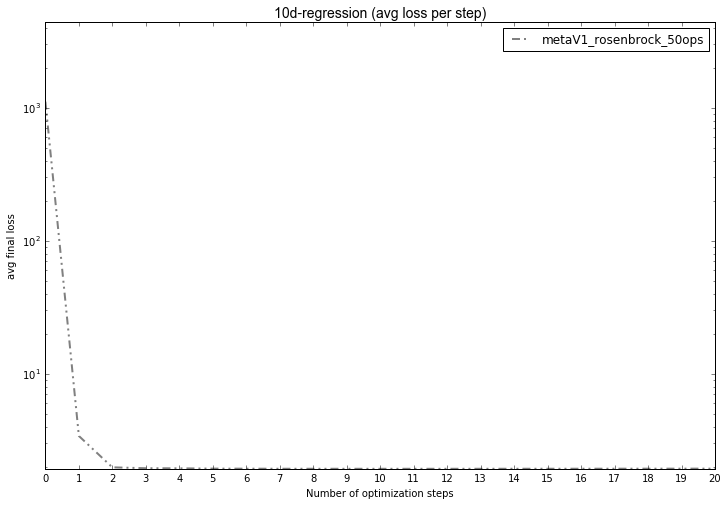

In [6]:
# new_exp_only = [new_experiments[5], new_experiments[6], new_experiments[7]] 
best_val_runs, lowest_value = plot_loss_over_tsteps(experiments, do_show=True, 
                                              do_save=False, 
                                              plot_best=False,
                                              fig_name="10_reg_meta_compare_fixed_weights_20steps", 
                                              loss_type="loss",
                                              min_step=0,
                                              max_step=20,
                                              sort_exper="10d-regression",
                                              log_scale=True,
                                              with_stddev=False,
                                              runID=None)

INFO - Successfully saved fig logs/run_20170719_08_53_21_metaV1_40ep_50ops_lr5e04_adam/loss_optimizer_metaV1_40ep_50ops_09:09:38.png


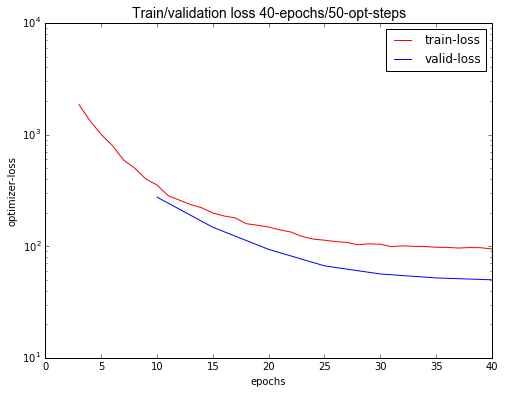

In [7]:
loss_plot(experiments[0], loss_type="opt_loss", save=True, validation=True, show=True, log_scale=True)

In [ ]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [3]:
val_funcs = RegressionFunction(n_funcs=15000, n_samples=10, stddev=1.0, 
                             x_dim=10, use_cuda=True)
with open("data/val_funcs_15000_10_1.0_10.dll", 'wb') as f:
     dill.dump(val_funcs, f)
print("Success")

Success


In [4]:
"""
    Create some new validation functions
"""
num_of_val_funcs = 20000
            val_funcs = L2LQuadratic(batch_size=num_of_val_funcs, num_dims=10, stddev=0.01, use_cuda=True)
print("Ready")

Ready


In [87]:
with open("data/val_funcs_20000_10_1.0_10.dll", 'rb') as f:
    val_funcs = dill.load(f)
print("Success")

Success


In [6]:
test_funcs = RegressionFunction(n_funcs=20000, n_samples=10, stddev=1., 
                             x_dim=10, use_cuda=True, calc_true_params=False)
with open("data/test_funcs_20000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

Ready


In [4]:
with open("data/test_funcs_20000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


In [7]:
print(len(new_experiments))
exp_idx = 5
max_steps = 100
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=True, save_run="test20000")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model metaV3.2_regression_100ops with 20000 functions


6
Validating model metaV3.2_regression_100ops with q-prob 0.300


INFO - INFO - Epoch 400, elapsed time 17.33 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 1.06e+03/9.431/0.2418
INFO - INFO - Epoch 400: Final step losses: [ 64.786  17.415  15.958  14.267  12.657  12.022  11.654  11.372  11.05
  10.822  10.673  10.562  10.444  10.344  10.27   10.207  10.148  10.094
  10.05   10.014   9.979   9.943   9.913   9.887   9.862   9.837   9.815
   9.795   9.776   9.759   9.742   9.727   9.713   9.7     9.686   9.675
   9.664   9.653   9.644   9.634   9.626   9.617   9.609   9.602   9.595
   9.588   9.582   9.575   9.57    9.564   9.559   9.553   9.549   9.544
   9.539   9.535   9.531   9.527   9.523   9.519   9.516   9.512   9.509
   9.506   9.502   9.499   9.496   9.494   9.491   9.488   9.486   9.483
   9.481   9.478   9.476   9.474   9.471   9.469   9.467   9.465   9.463
   9.461   9.459   9.457   9.455   9.454   9.452   9.45    9.448   9.447
   9.445   9.444   9.442   9.441   9.439   9.438

INFO - Successfully saved experimental details to logs/run_20170713_16_39_30_metaV3.2_10ep_100ops_retrain_lr1e04_adam/exp_statistics_test20000.dll


In [4]:
del new_experiments
new_experiments = []

for exper in expers_to_load:
    if exper[0]:
        new_experiments.append(get_experiment(path_to_exp=exper[1] + "/" + "exp_statistics_test20000.dll",
                                              full_path=True))
print("Ready")

Ready


('Key ', 100)
INFO - Successfully saved fig logs/run_20170711_08_40_14_actV2_30ep_31ops_retrain_lr5e05_adam/qt_T_dist_val_actV2_30ep_31ops_retrain.png


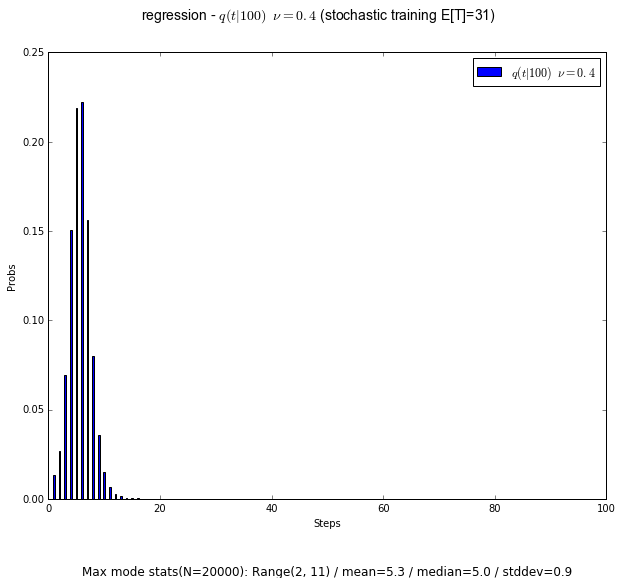

In [5]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [122]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

('key ', 100)


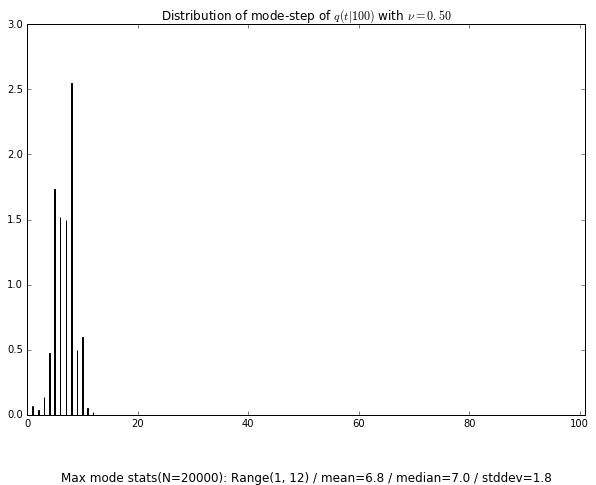

In [23]:
plot_qt_mode_hist(new_experiments[1], do_save=False, do_show=True, add_info=True)

In [ ]:
def compute_yt(W, x):
    return torch.transpose(torch.mm(W ,x.unsqueeze(1)), 1,0)

def compute_params(W, y, cuda=False):
    
    A_plus = np.linalg.pinv(W.data.cpu().numpy())
    y = y.data.cpu().numpy()
    params = np.squeeze(np.dot(A_plus, y))
    params = Variable(torch.from_numpy(params).float().unsqueeze(0))
    if cuda:
        params = params.cuda()
    return params
    


Run with key 100
INFO - Successfully saved fig logs/run_20170711_08_40_14_actV2_30ep_31ops_retrain_lr5e05_adam/qt_detailed_stats_actV2_30ep_31ops_retrain.png


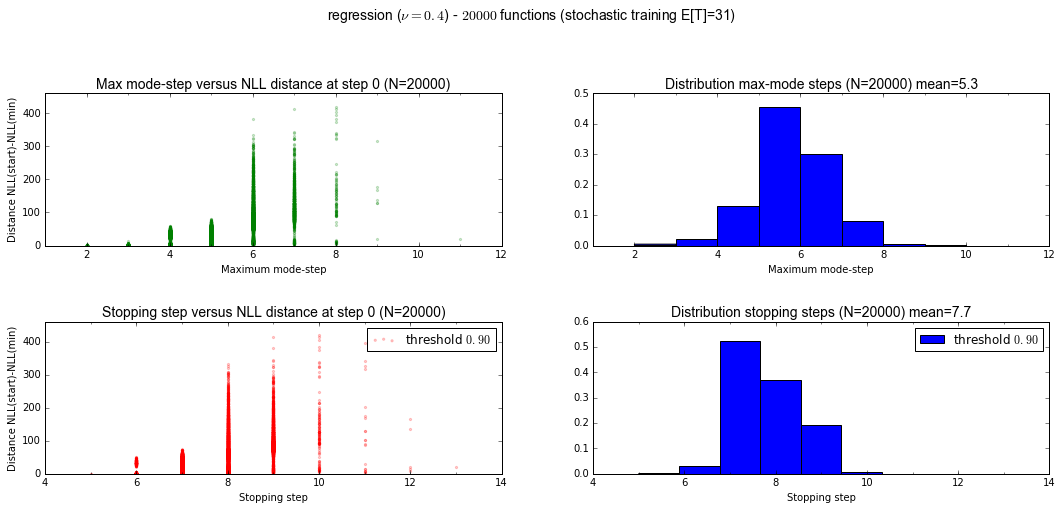

In [8]:
plot_qt_detailed_stats(new_experiments[2], test_funcs, do_save=True, do_show=True, threshold=0.90)

In [ ]:
 # 
plot_kl_div_parts(new_experiments[1], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

In [23]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

s = 0.05   # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-1.2, 4+s, s)   #Could use linspace instead if dividing
Y = np.arange(10, 13+s, s)   #evenly instead of stepping...
    
#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (3.5-X)**2 + 100.*(Y-X*X)**2

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
         linewidth=0, antialiased=False)  #Try coolwarm vs jet

plt.xlabel('x')
plt.ylabel('y')
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

#Displays the figure, handles user interface, returns when user closes window
plt.show()

In [19]:
rosenbrockfunction = lambda x,y: (3.5-x)**2+100*(y-x**2)**2

fig = plt.figure(figsize=(8, 6))
n = 100 # number of discretization points along the x-axis
m = 100 # number of discretization points along the x-axis
a=-2.5; b=4 # extreme points in the x-axis
c=8; d=10 # extreme points in the y-axis

X,Y = np.meshgrid(np.linspace(a,b,n), np.linspace(c,d,m))

Z = rosenbrockfunction(X,Y)

plt.contour(X,Y,Z,np.logspace(-0.5,3.5,20,base=10),cmap='gray')
plt.title(r'$\textrm{Rosenbrock Function: } f(x,y)=(1-x)^2+100(y-x^2)^2$')
plt.xlabel('x')
plt.ylabel('y')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.show()


/home/jogi/.local/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: covariance is not positive-semidefinite.


<IPython.core.display.Javascript object>


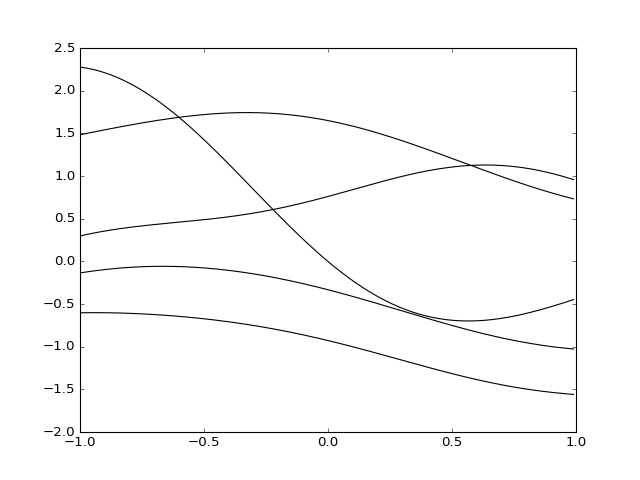

In [10]:
#!/usr/bin/python

from math import exp


def rbf_kernel(x1, x2, variance = 1):
    return exp(-1 * ((x1-x2) ** 2) / (2*variance))

def gram_matrix(xs):
    return [[rbf_kernel(x1,x2) for x2 in xs] for x1 in xs]

xs = np.arange(-1, 1, 0.01)
mean = [0 for x in xs]
gram = gram_matrix(xs)

plt_vals = []
for i in range(0, 5):
    ys = np.random.multivariate_normal(mean, gram)
    plt_vals.extend([xs, ys, "k"])
plt.plot(*plt_vals)
plt.show()

In [ ]:
expers_to_load = [# Meta V3 model regression
                  (True, "run_20170713_17_03_57_metaV1_10ep_100ops_retrain_lr1e04_adam"), # weights=1
                  (True, "run_20170713_16_12_22_metaV3.1_10ep_100ops_lr1e04_adam"),  # nu=0.3, 10 epochs
                  (True, "run_20170714_10_28_31_metaV3.1_10ep_100ops_lr1e04_adam"), # nu=0.5, 10 epochs
                  (True, "run_20170713_17_16_28_metaV3.1_16ep_100ops_lr1e04_adam"), # nu=0.7, 14 epochs
                  (True, "run_20170713_17_15_05_metaV3.1_16ep_100ops_lr1e04_adam"), # nu=0.9, 16 epochs
                  (True, "run_20170713_16_39_30_metaV3.2_10ep_100ops_retrain_lr1e04_adam")] # uniform, 12 epochs